In [1]:
!git clone 'https://github.com/sachin327/images'

Cloning into 'images'...
remote: Enumerating objects: 370, done.
remote: Counting objects: 100% (370/370), done.
remote: Compressing objects: 100% (369/369), done.
remote: Total 370 (delta 1), reused 369 (delta 0), pack-reused 0
Receiving objects: 100% (370/370), 7.18 MiB | 4.58 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [2]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [3]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator

In [5]:
from keras import backend as K

In [6]:
import keras
from sklearn.utils import shuffle

In [7]:
from keras.optimizers import SGD

In [8]:
import pandas as pd
import h5py
import time

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy')

553467904/553467096 [==============================] - 15s 0us/step


In [10]:
%cd '//content'

/content


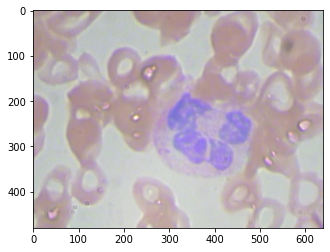

In [11]:
img=Image.open('images/BloodImage_00000.jpg')
plt.imshow(img)

(1, 480, 640, 3)


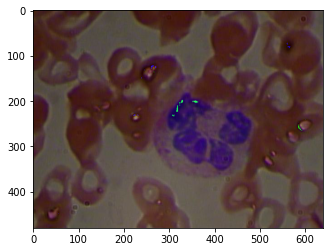

In [12]:
mean_pixel = [103.939, 116.779, 123.68]
img = np.array(img)
for c in range(3):
  img[:, :, c] = img[:, :, c] - mean_pixel[c]
        
img = img.reshape(1,img.shape[0],img.shape[1],3)
print(img.shape)
plt.imshow(img[0])

In [13]:
start=time.time()
input1 = model.input
output1 = model.layers[15].output
fun = K.function([input1, K.learning_phase()],output1)
layer_outputs = fun([img, 1.])

print(time.time()-start)

6.137122631072998


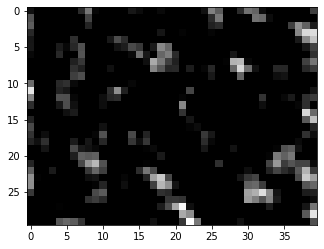

In [14]:
plt.imshow(layer_outputs[0][:,:,0],cmap='gray')

In [15]:
def area(x1,x2,y1,y2):
    r=(x2-x1)*(y2-y1)
    return r

In [16]:
def iou(x1,x2,y1,y2,x1_,x2_,y1_,y2_):
    x11=max(x1,x1_)
    y11=max(y1,y1_)
    x12=min(x2,x2_)
    y12=min(y2,y2_)
    if(x11>x12 or y11>y12):
        return 0
    i=area(x11,x12,y11,y12)/(area(x1,x2,y1,y2)+area(x1_,x2_,y1_,y2_)-area(x11,x12,y11,y12))
    return i

In [17]:
a=pd.read_csv('images/bl_data.csv')

In [18]:
a.head(3)

,filename,cell_type,xmin,xmax,ymin,ymax
0,BloodImage_00000.jpg,WBC,260,491,177,376
1,BloodImage_00000.jpg,RBC,78,184,336,435
2,BloodImage_00000.jpg,RBC,63,169,237,336


In [19]:
x=[]
y=[]
y1=[]
s=""
mean_pixel = [103.939, 116.779, 123.68]
for i in range(len(a['filename'])):
    y2=[]
    if(s!=a['filename'][i]):
        y.append(y1)
        y1=[]
        im=Image.open('images/'+a['filename'][i])
        
        im = np.array(im)
        for c in range(3):
            im[:, :, c] = im[:, :, c] - mean_pixel[c]
        
        x.append(im)
    if(a['cell_type'][i]=='RBC'):
        y2.append(0)
    if(a['cell_type'][i]=='WBC'):
        y2.append(1)
    if(a['cell_type'][i]=='Platelets'):
        y2.append(2)
    y2.append(a['xmin'][i])
    y2.append(a['xmax'][i])
    y2.append(a['ymin'][i])
    y2.append(a['ymax'][i])
    y1.append(y2)
    s=a['filename'][i]
y.append(y1)
y=y[1:]

In [20]:
x=np.array(x)

In [21]:
x.shape

(364, 480, 640, 3)

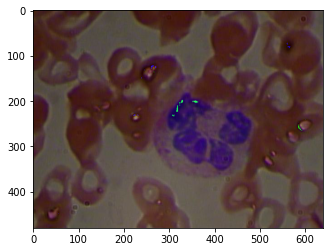

In [22]:
plt.imshow(x[0])

In [23]:
ratios = [0.5, 1, 2]
anchor_scales = [7, 13]
sub_sample=16
ctr_x = np.arange(16, (40+1) * 16, 16)
ctr_y = np.arange(16, (30+1) * 16, 16)

In [24]:
ctr_x,ctr_y

(array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416,
        432, 448, 464, 480, 496, 512, 528, 544, 560, 576, 592, 608, 624,
        640]),
 array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 272, 288, 304, 320, 336, 352, 368, 384, 400, 416,
        432, 448, 464, 480]))

In [25]:
index = 0
ctr=np.zeros((1200,2))
for x_ in range(len(ctr_x)):
    for y_ in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x_] - 8
        ctr[index, 0] = ctr_y[y_] - 8
        index +=1

In [26]:
ctr

array([[  8.,   8.],
       [ 24.,   8.],
       [ 40.,   8.],
       ...,
       [440., 632.],
       [456., 632.],
       [472., 632.]])

In [27]:
anchors = np.zeros((40 * 30 * 6, 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
            w =sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])
            anchors[index, 0] = ctr_x - w / 2.
            anchors[index, 1] = ctr_x + w / 2.
            anchors[index, 2] = ctr_y - h / 2.
            anchors[index, 3] = ctr_y + h / 2.
            index += 1
print(anchors.shape)

(7200, 4)


In [28]:
s=0
for i in range(7200):
    if(anchors[i][0]>=0 and anchors[i][2]>=0 and anchors[i][1]<=640 and anchors[i][3]<=480):
        s=s+1
    else:
        anchors[i]=0
s

3620

In [244]:
input1 = model.input
output1 = model.layers[15].output
fun = K.function([input1, K.learning_phase()],output1)
batchx=[]
batchy=[]
batchx3=[]
batchy3=[]
for l in range(150):
    start=time.time()
    layer_outputs = fun([x[l:l+1], 1.])
    anch=np.zeros((7200,len(y[l])))
    batchx1=[]
    batchy1=[]
    batchx2=[]
    batchy2=[]
    for i in range(7200):
        if (anchors[i][0]==0 and anchors[i][1]==0 and anchors[i][2]==0 and anchors[i][3]==0):
            continue
        for j in range(len(y[l])):
            a1=iou(anchors[i][0],anchors[i][1],anchors[i][2],anchors[i][3],y[l][j][1],y[l][j][2],y[l][j][3],y[l][j][4])
            anch[i][j]=a1
    a4=np.argmax(anch,axis=1)
    b1=np.amax(anch,axis=1)
    del anch
    for ii in range(7200):
        if (anchors[ii][0]==0 and anchors[ii][1]==0 and anchors[ii][2]==0 and anchors[ii][3]==0):
            continue
        if (b1[ii]>=0.7):
            y_=int(np.round(anchors[ii][2]/16))
            x_=int(np.round(anchors[ii][0]/16))
            w_=int(np.round((anchors[ii][1]-anchors[ii][0])/16))
            h_=int(np.round((anchors[ii][3]-anchors[ii][2])/16))
            w1_=int(w_/3)
            h1_=int(h_/3)
            a1=layer_outputs[0][y_:y_+h_,x_:x_+w_,:]
            a2=np.zeros((3,3,512))
            for i in range(3):
              if (i==2):
                for j in range(3):
                  if (j==2):
                    a2[i:i+1,j:j+1,:]=np.amax(np.amax(a1[i*h1_:,j*w1_:,:],axis=1),axis=0).reshape(1,1,512)
                    break
                  a2[i:i+1,j:j+1,:]=np.amax(np.amax(a1[i*h1_:,j*w1_:(j+1)*w1_,:],axis=1),axis=0).reshape(1,1,512)
                break
              for j in range(3):
                if (j==2):
                  a2[i:i+1,j:j+1,:]=np.amax(np.amax(a1[i*h1_:(i+1)*h1_,j*w1_:,:],axis=1),axis=0).reshape(1,1,512)
                  break
                a2[i:i+1,j:j+1,:]=np.amax(np.amax(a1[i*h1_:(i+1)*h1_,j*w1_:(j+1)*w1_,:],axis=1),axis=0).reshape(1,1,512)
            
            batchx1.append(a2)
            batchy1.append(y[l][a4[ii]][0]+1)
            batchx3.append([(anchors[ii][1]+anchors[ii][0])/2,(anchors[ii][3]+anchors[ii][2])/2,(anchors[ii][1]-anchors[ii][0]),(anchors[ii][3]-anchors[ii][2])])
            batchy3.append([(y[l][a4[ii]][2]+y[l][a4[ii]][1])/2,(y[l][a4[ii]][4]+y[l][a4[ii]][3])/2,y[l][a4[ii]][2]-y[l][a4[ii]][1],(y[l][a4[ii]][4]-y[l][a4[ii]][3])])
            
        elif (b1[ii]<0.3):
            y_=int(np.round(anchors[ii][2]/16))
            x_=int(np.round(anchors[ii][0]/16))
            w_=int(np.round((anchors[ii][1]-anchors[ii][0])/16))
            h_=int(np.round((anchors[ii][3]-anchors[ii][2])/16))
            w1_=int(w_/3)
            h1_=int(h_/3)
            a1=layer_outputs[0][y_:y_+h_,x_:x_+w_,:]
            a2=np.zeros((3,3,512))
            for i in range(3):
              if (i==2):
                for j in range(3):
                  if (j==2):
                    a2[i:i+1,j:j+1,:]=np.amax(np.amax(a1[i*h1_:,j*w1_:,:],axis=1),axis=0).reshape(1,1,512)
                    break
                  a2[i:i+1,j:j+1,:]=np.amax(np.amax(a1[i*h1_:,j*w1_:(j+1)*w1_,:],axis=1),axis=0).reshape(1,1,512)
                break
              for j in range(3):
                if (j==2):
                  a2[i:i+1,j:j+1,:]=np.amax(np.amax(a1[i*h1_:(i+1)*h1_,j*w1_:,:],axis=1),axis=0).reshape(1,1,512)
                  break
                a2[i:i+1,j:j+1,:]=np.amax(np.amax(a1[i*h1_:(i+1)*h1_,j*w1_:(j+1)*w1_,:],axis=1),axis=0).reshape(1,1,512)
            batchx2.append(a2)
            batchy2.append(0)
            
    s=len(batchx1)
    batchx2,batchy2=shuffle(batchx2, batchy2, random_state=0)
    batchx2=batchx2[0:s]
    batchy2=batchy2[0:s]
    batchx1=batchx1+batchx2
    batchy1=batchy1+batchy2
    batchx=batchx+batchx1
    batchy=batchy+batchy1
    print(l,len(batchx1),len(batchy1),time.time()-start)
    

0 64 64 1.5248422622680664
1 54 54 1.4922184944152832
2 76 76 1.3184349536895752
3 80 80 1.3209521770477295
4 42 42 1.2635550498962402
5 84 84 1.5500426292419434
6 50 50 1.3352775573730469
7 102 102 1.4103741645812988
8 92 92 1.4945788383483887
9 44 44 1.333519458770752
10 40 40 1.3918838500976562
11 72 72 1.436138391494751
12 76 76 1.4988453388214111
13 70 70 1.2935843467712402
14 44 44 1.4520480632781982
15 58 58 1.3813276290893555
16 56 56 1.1399164199829102
17 64 64 1.3972969055175781
18 40 40 1.5617005825042725
19 86 86 1.3574674129486084
20 94 94 1.6948847770690918
21 72 72 1.3335449695587158
22 60 60 1.3282561302185059
23 64 64 1.361609935760498
24 66 66 1.316918134689331
25 84 84 1.358245849609375
26 52 52 1.5056567192077637
27 74 74 1.5914382934570312
28 54 54 1.7399532794952393
29 58 58 1.6331219673156738
30 82 82 1.6835637092590332
31 56 56 1.507948875427246
32 50 50 1.3800675868988037
33 70 70 1.5003597736358643
34 84 84 1.46388840675354
35 74 74 1.9080986976623535
36 32 32

In [93]:
xtrain=np.array(batchx)
ytrain=np.array(batchy)

In [ ]:
hf = h5py.File('data.h5', 'w')

In [ ]:
hf.create_dataset('dataset_1', data=xtrain)
hf.create_dataset('dataset_2', data=ytrain)

<HDF5 dataset "dataset_2": shape (5360,), type "<i8">

In [ ]:
hf.keys()

<KeysViewHDF5 ['dataset_1', 'dataset_2']>

In [ ]:
hf.close()

In [94]:
xtrain,ytrain=shuffle(xtrain,ytrain,random_state=0)

In [95]:
xtrain.shape

(7282, 3, 3, 512)

In [96]:
xval=xtrain[0:1000]
yval=ytrain[0:1000]

In [97]:
xtest=xtrain[1000:2000]
ytest=ytrain[1000:2000]

In [98]:
xtrain=xtrain[2000:]
ytrain=ytrain[2000:]

In [99]:
number_cat=4
ytrain = keras.utils.to_categorical(ytrain, number_cat)
yval = keras.utils.to_categorical(yval, number_cat)

In [100]:
ytest = keras.utils.to_categorical(ytest, number_cat)

In [101]:
ytrain

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [102]:
model1 = Sequential()
model1.add(Conv2D(512, kernel_size=3, activation='relu', input_shape=(3,3,512)))

model1.add(Flatten())

model1.add(Dense(4, activation='softmax'))

In [103]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 1, 512)         2359808   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 2,361,860
Trainable params: 2,361,860
Non-trainable params: 0
_________________________________________________________________


In [104]:
yval

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [105]:
ytrain

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
model1.compile(loss = "categorical_crossentropy", optimizer= keras.optimizers.Adam(learning_rate=0.0001), metrics = ["accuracy"])
history = model1.fit(xtrain/255, ytrain, epochs = 100, batch_size = 64 , validation_data = (xval/255,yval), verbose = 1) 

In [108]:
evaluation = model1.evaluate(xtest/255, ytest)
print("test accuracy: {}" .format(evaluation[1]))

test accuracy: 0.9670000076293945


In [109]:
y_=model1.predict(xtest[0:1]/255)

In [110]:
yy_=np.argmax(y_,axis=1)[0]

In [112]:
y_

array([[1.0000000e+00, 5.6854896e-33, 2.2252660e-24, 6.1958108e-34]],
      dtype=float32)

In [245]:
xtrain_=np.array(batchx3)
ytrain_=np.array(batchy3)

In [246]:
xtrain_

array([[104., 280., 112., 112.],
       [120., 184., 112., 112.],
       [120., 200., 112., 112.],
       ...,
       [536., 312., 112., 112.],
       [552., 296., 112., 112.],
       [584., 216., 112., 112.]])

In [247]:
ytrain_

array([[116. , 286.5, 106. ,  99. ],
       [126.5, 189.5, 115. ,  91. ],
       [126.5, 189.5, 115. ,  91. ],
       ...,
       [543.5, 300.5, 107. , 103. ],
       [543.5, 300.5, 107. , 103. ],
       [591.5, 217. ,  97. , 104. ]])

In [248]:
xtrain_.shape

(3641, 4)

In [249]:
xval_=xtrain_[0:500]
yval_=ytrain_[0:500]

In [250]:
xtest_=xtrain_[500:1000]
ytest_=ytrain_[500:1000]

In [251]:
xtrain_=xtrain_[1000:]
ytrain_=ytrain_[1000:]

In [252]:
xtrain_.shape

(2641, 4)

In [253]:
model2 = Sequential()
model2.add(Dense(4,input_shape=[4]))


In [254]:
model2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 4)                 20        
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


In [255]:
def box_loss(y_actual,y_prediction):
  loss = (1/2641) * tf.reduce_sum((y_actual-y_prediction)*(y_actual-y_prediction))
  return loss

In [256]:
model2.compile(loss = box_loss, optimizer= keras.optimizers.Adam(learning_rate=0.01), metrics = ["accuracy"])
history = model2.fit(xtrain_, ytrain_, epochs = 100, batch_size = 64 , validation_data = (xval_,yval_), verbose = 1) 

Train on 2641 samples, validate on 500 samples
Epoch 1/100
2641/2641 [==============================] - 0s 53us/sample - loss: 666.9078 - accuracy: 0.8769 - val_loss: 456.3655 - val_accuracy: 0.9340
Epoch 2/100
2641/2641 [==============================] - 0s 25us/sample - loss: 212.4865 - accuracy: 0.9353 - val_loss: 189.0018 - val_accuracy: 0.8960
Epoch 3/100
2641/2641 [==============================] - 0s 25us/sample - loss: 87.4007 - accuracy: 0.9474 - val_loss: 82.9443 - val_accuracy: 0.9080
Epoch 4/100
2641/2641 [==============================] - 0s 26us/sample - loss: 41.4658 - accuracy: 0.9553 - val_loss: 42.4847 - val_accuracy: 0.9140
Epoch 5/100
2641/2641 [==============================] - 0s 24us/sample - loss: 24.3636 - accuracy: 0.9599 - val_loss: 26.6558 - val_accuracy: 0.9260
Epoch 6/100
2641/2641 [==============================] - 0s 24us/sample - loss: 17.8462 - accuracy: 0.9633 - val_loss: 20.0677 - val_accuracy: 0.9300
Epoch 7/100
2641/2641 [==========================

In [257]:
evaluation = model2.evaluate(xtest_, ytest_)
print("test accuracy: {}" .format(evaluation[1]))

test accuracy: 0.9620000123977661


In [258]:
model2.predict(xtest_)

array([[117.49017 , 120.055885, 112.52917 , 107.7785  ],
       [149.00133 , 344.46042 , 110.881485, 107.54507 ],
       [227.77336 , 104.6815  , 211.9668  , 201.46156 ],
       ...,
       [228.8697  , 136.11594 , 111.373566, 107.8345  ],
       [276.3409  , 328.46854 , 109.766655, 107.64804 ],
       [292.25552 , 328.47308 , 109.615295, 107.65864 ]], dtype=float32)

In [259]:
ytest_

array([[113.5, 115.5, 103. , 107. ],
       [147.5, 345.5, 113. ,  91. ],
       [253. , 122. , 216. , 236. ],
       ...,
       [221.5, 137.5, 127. , 121. ],
       [288. , 326.5, 110. , 105. ],
       [288. , 326.5, 110. , 105. ]])

In [219]:
from matplotlib import patches

0.10899782180786133


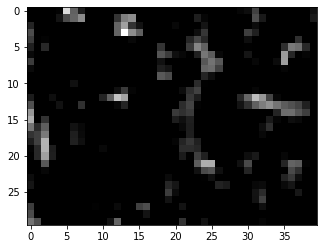

In [260]:
img=Image.open('images/BloodImage_00152.jpg')
mean_pixel = [103.939, 116.779, 123.68]
img = np.array(img)
for c in range(3):
  img[:, :, c] = img[:, :, c] - mean_pixel[c]
        
img = img.reshape(1,img.shape[0],img.shape[1],3)
start=time.time()
input1 = model.input
output1 = model.layers[15].output
fun = K.function([input1, K.learning_phase()],output1)
layer_outputs = fun([img, 1.])

print(time.time()-start)
plt.imshow(layer_outputs[0][:,:,0],cmap='gray')

449


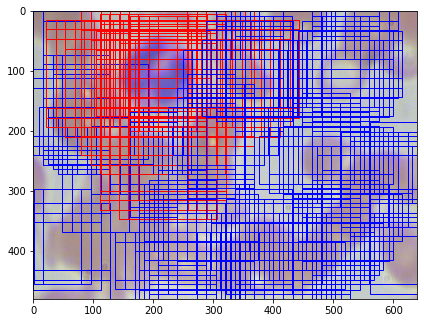

In [261]:
ll=['g','b','r','y']
arr1=[]
arr2=[]
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('images/BloodImage_00152.jpg')
plt.imshow(image)
s=0
# iterating over the image for different objects
for ii in range(7200):
    if (anchors[ii][0]==0 and anchors[ii][1]==0 and anchors[ii][2]==0 and anchors[ii][3]==0):
        continue
    else:
        y_=int(np.round(anchors[ii][2]/16))
        x_=int(np.round(anchors[ii][0]/16))
        w_=int(np.round((anchors[ii][1]-anchors[ii][0])/16))
        h_=int(np.round((anchors[ii][3]-anchors[ii][2])/16))
        w1_=int(w_/3)
        h1_=int(h_/3)
        a1=layer_outputs[0][y_:y_+h_,x_:x_+w_,:]
        a2=np.zeros((3,3,512))
        for i in range(3):
          if (i==2):
            for j in range(3):
              if (j==2):
                a2[i:i+1,j:j+1,:]=np.amax(np.amax(a1[i*h1_:,j*w1_:,:],axis=1),axis=0).reshape(1,1,512)
                break
              a2[i:i+1,j:j+1,:]=np.amax(np.amax(a1[i*h1_:,j*w1_:(j+1)*w1_,:],axis=1),axis=0).reshape(1,1,512)
            break
          for j in range(3):
            if (j==2):
              a2[i:i+1,j:j+1,:]=np.amax(np.amax(a1[i*h1_:(i+1)*h1_,j*w1_:,:],axis=1),axis=0).reshape(1,1,512)
              break
            a2[i:i+1,j:j+1,:]=np.amax(np.amax(a1[i*h1_:(i+1)*h1_,j*w1_:(j+1)*w1_,:],axis=1),axis=0).reshape(1,1,512)
        a2=a2.reshape((1,3,3,512))
        a5=model1.predict(a2)
        a6=np.argmax(a5,axis=1)[0]
        if (a6!=0 and a5[0][a6]>0.99):
          s=s+1
          xmin = anchors[ii][0]
          xmax = anchors[ii][1]
          ymin = anchors[ii][2]
          ymax = anchors[ii][3]
          
          width = xmax - xmin
          height = ymax - ymin
          arr1.append((anchors[ii],a6))
          arr2.append([(anchors[ii][1]-anchors[ii][0])/2,(anchors[ii][3]-anchors[ii][2])/2,(anchors[ii][1]-anchors[ii][0]),(anchors[ii][3]-anchors[ii][2])])
          # assign different color to different classes of objects
          # add bounding boxes to the image
          rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = ll[arr1[-1][1]], facecolor = 'none')
          
          ax.add_patch(rect)
print(s)

In [262]:
# Applying Non Max Suppression
i=0
while (i<len(arr1)):
  j=i+1
  while (j<len(arr1)):
    a1=iou(arr1[i][0][0],arr1[i][0][1],arr1[i][0][2],arr1[i][0][3],arr1[j][0][0],arr1[j][0][1],arr1[j][0][2],arr1[j][0][3])
    if (a1>0.1 and arr1[i][1]==arr1[j][1]):
      del arr1[j]
      del arr2[j]
      j=j-1
    j=j+1
  i=i+1


In [263]:
len(arr1),len(arr2)

(18, 18)

18


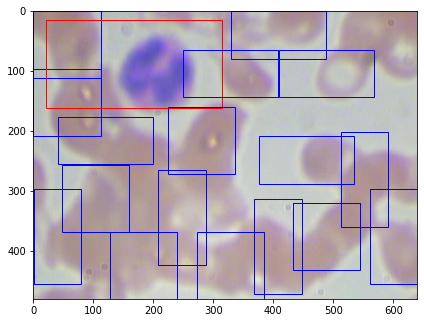

In [269]:
ll=['g','b','r','y']
fig = plt.figure()

#add axes to the image
ax = fig.add_axes([0,0,1,1])

# read and plot the image
image = plt.imread('images/BloodImage_00152.jpg')
plt.imshow(image)
s=0
# iterating over the image for different objects
for ii in range(len(arr1)):
    if (True):
          xmin = arr1[ii][0][0]
          xmax = arr1[ii][0][1]
          ymin = arr1[ii][0][2]
          ymax = arr1[ii][0][3]
          
          width = xmax - xmin
          height = ymax - ymin
          # assign different color to different classes of objects
          # add bounding boxes to the image
          rect = patches.Rectangle((xmin,ymin), width, height, edgecolor = ll[arr1[ii][1]], facecolor = 'none')
          s=s+1
          ax.add_patch(rect)
print(s)

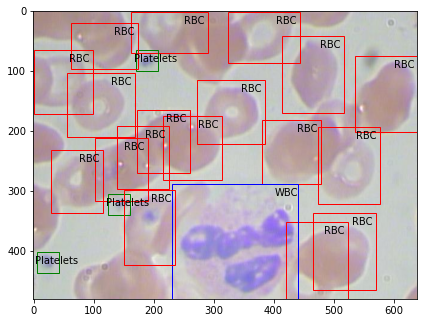

In [126]:
y[130]

[[1, 128, 281, 31, 172]]

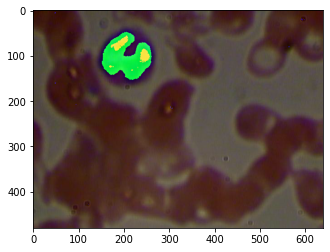

In [127]:
plt.imshow(x[130])

In [139]:
jjhj=(1,2)

In [142]:
a123=[1,2,3]
a231=[2,3,1]
a321=[3,2,1]
a123,a231,a321=shuffle(a123,a231,a321,random_state=0)

In [143]:
a123,a231,a321


([3, 2, 1], [1, 3, 2], [1, 2, 3])

In [ ]:
[(y[l][a4[ii]][2]-y[l][a4[ii]][1])/2

In [149]:
y[5][1][2]

[[0, 273, 386, 115, 222],
 [0, 56, 169, 103, 210],
 [0, 414, 518, 42, 170],
 [0, 536, 640, 74, 202],
 [0, 474, 578, 193, 321],
 [0, 466, 570, 337, 465],
 [0, 420, 524, 352, 480],
 [0, 215, 314, 174, 281],
 [0, 380, 479, 181, 288],
 [0, 1, 99, 64, 171],
 [0, 324, 444, 1, 87],
 [0, 162, 290, 1, 70],
 [0, 173, 260, 165, 270],
 [0, 139, 226, 191, 296],
 [0, 103, 190, 211, 316],
 [0, 29, 116, 231, 336],
 [2, 170, 207, 65, 100],
 [2, 6, 43, 401, 436],
 [2, 124, 161, 305, 340],
 [1, 230, 441, 288, 480],
 [0, 151, 236, 298, 423],
 [0, 63, 174, 19, 97]]